/tmp/ipykernel_6404/1850767402.py:98: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  new_row[training_period - 1] = next_pred[0]  # Add the new prediction as the latest lag
/tmp/ipykernel_6404/1850767402.py:98: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  new_row[training_period - 1] = next_pred[0]  # Add the new prediction as the latest lag
/tmp/ipykernel_6404/1850767402.py:98: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = va

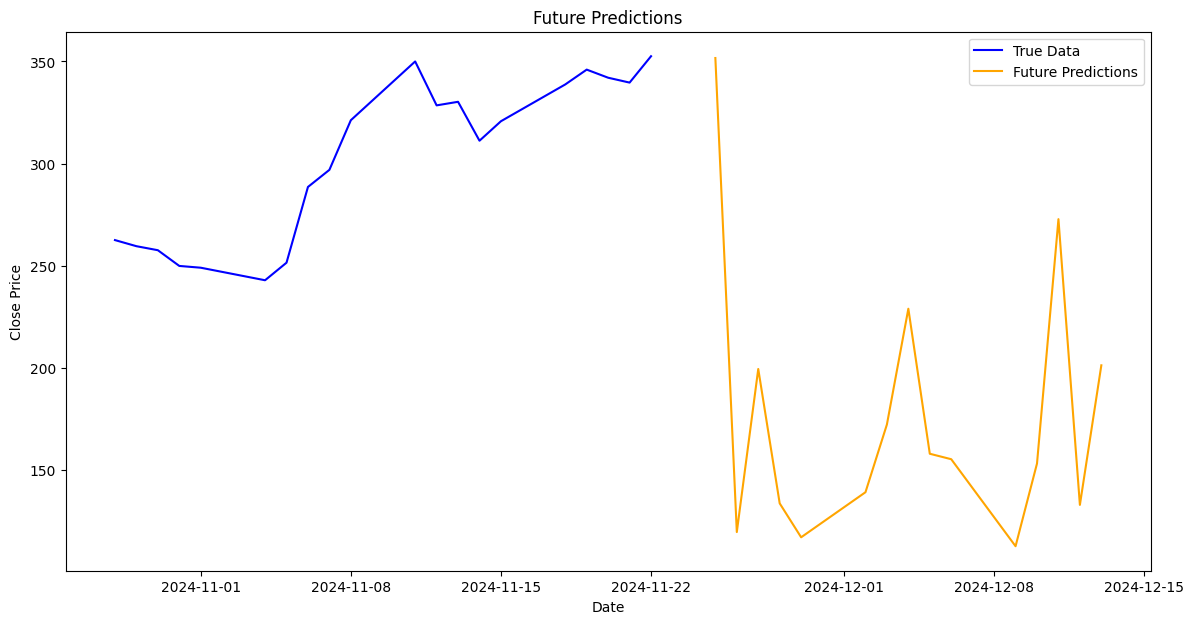

Future Predictions:
2024-11-25: 351.68
2024-11-26: 119.51
2024-11-27: 199.38
2024-11-28: 133.56
2024-11-29: 116.95
2024-12-02: 139.02
2024-12-03: 172.19
2024-12-04: 228.89
2024-12-05: 157.87
2024-12-06: 155.19
2024-12-09: 112.58
2024-12-10: 153.09
2024-12-11: 272.77
2024-12-12: 132.82
2024-12-13: 201.18


/tmp/ipykernel_6404/1850767402.py:98: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  new_row[training_period - 1] = next_pred[0]  # Add the new prediction as the latest lag
/tmp/ipykernel_6404/1850767402.py:98: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  new_row[training_period - 1] = next_pred[0]  # Add the new prediction as the latest lag
/tmp/ipykernel_6404/1850767402.py:98: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = va

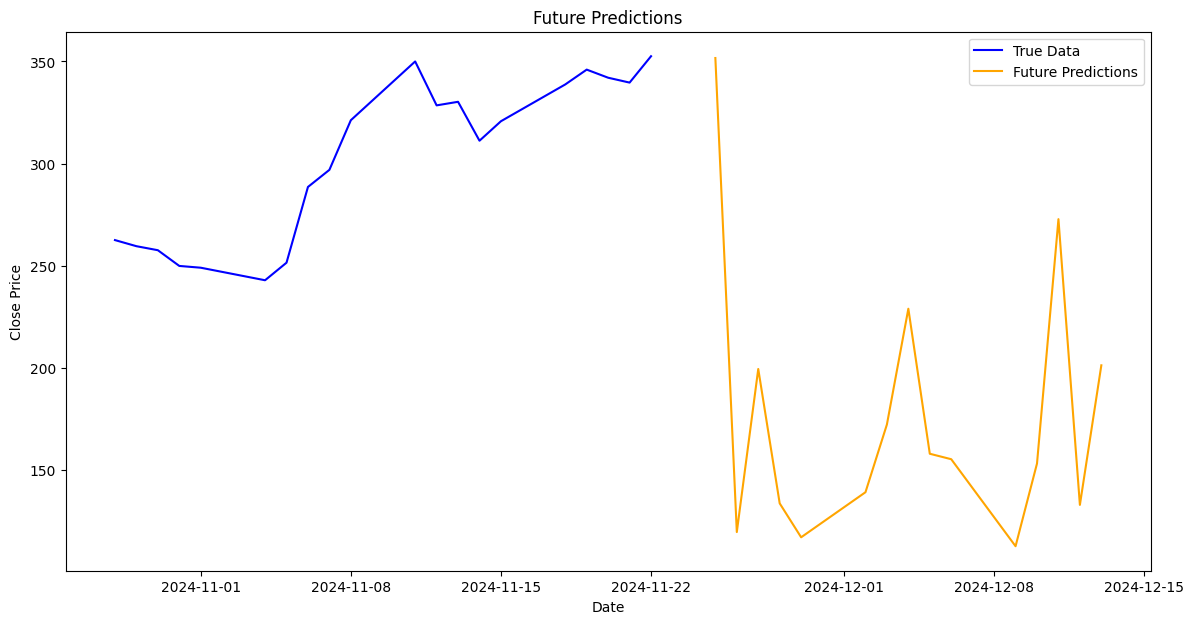

Future Predictions:
2024-11-25: 351.68
2024-11-26: 119.51
2024-11-27: 199.38
2024-11-28: 133.56
2024-11-29: 116.95
2024-12-02: 139.02
2024-12-03: 172.19
2024-12-04: 228.89
2024-12-05: 157.87
2024-12-06: 155.19
2024-12-09: 112.58
2024-12-10: 153.09
2024-12-11: 272.77
2024-12-12: 132.82
2024-12-13: 201.18


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Function to create lag features and rolling statistics
def create_lag_features(data, lags):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data['Close'].pct_change(lag)  # Percentage change
    data['rolling_mean'] = data['Close'].rolling(window=5).mean()
    data['rolling_std'] = data['Close'].rolling(window=5).std()
    return data

# Function to split the dataset
def split_data(df, training_period, train_ratio=0.8):
    # Create lag features and rolling statistics
    df = create_lag_features(df, training_period)
    df.dropna(inplace=True)  # Remove rows with NaN values

    # Scale features
    feature_scaler = StandardScaler()
    scaled_features = feature_scaler.fit_transform(df.drop(columns=['Close']))
    scaled_data = pd.DataFrame(scaled_features, columns=df.drop(columns=['Close']).columns, index=df.index)
    scaled_data['Close'] = df['Close']  # Keep original target for splitting

    # Scale the target variable
    target_scaler = StandardScaler()
    scaled_data['Close'] = target_scaler.fit_transform(df['Close'].values.reshape(-1, 1)).ravel()

    # Split data
    split_idx = int(len(df) * train_ratio)
    train_data = scaled_data.iloc[:split_idx]
    test_data = scaled_data.iloc[split_idx:]

    # Separate features and targets
    X_train = train_data.drop(columns=['Close'])
    y_train = train_data['Close']
    X_test = test_data.drop(columns=['Close'])
    y_test = test_data['Close']

    return X_train, y_train, X_test, y_test, test_data.index, feature_scaler, target_scaler

# Function to train the XGBoost model
def train_xgboost(X_train, y_train):
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        objective='reg:squarederror',
        random_state=42
    )
    model.fit(X_train, y_train)
    return model
# Function to calculate log-return volatility
def calculate_log_volatility(y_values):
    log_returns = np.log(y_values[1:] / y_values[:-1])  # Logarithmic returns
    return np.std(log_returns)  # Volatility as standard deviation of log returns

def predict_next_days(data, training_period, n_days_to_predict):
    # Ensure the DataFrame index is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(data.index):
        data.index = pd.to_datetime(data.index)

    # Prepare the data for training
    data = create_lag_features(data, training_period).dropna()
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    # Scale the features and target variable
    scaled_features = feature_scaler.fit_transform(data.drop(columns=['Close']))
    scaled_data = pd.DataFrame(scaled_features, columns=data.drop(columns=['Close']).columns, index=data.index)
    scaled_data['Close'] = target_scaler.fit_transform(data['Close'].values.reshape(-1, 1)).ravel()

    # Split features and target
    X_train = scaled_data.drop(columns=['Close'])
    y_train = scaled_data['Close']

    # Train the model on the entire dataset
    model = train_xgboost(X_train, y_train)

    # Predict the next 15 days iteratively
    last_data = X_train.iloc[-training_period:].copy()  # Use the last available data for lag features
    future_predictions = []

    for i in range(n_days_to_predict):
        # Predict the next day
        next_pred = model.predict(last_data[-1:].values)  # Use the most recent data
        next_pred_unscaled = target_scaler.inverse_transform(next_pred.reshape(-1, 1)).ravel()[0]
        future_predictions.append(next_pred_unscaled)

        # Update the lag features
        new_row = last_data.iloc[-1].copy()
        new_row[0:training_period - 1] = new_row[1:training_period]  # Shift lags
        new_row[training_period - 1] = next_pred[0]  # Add the new prediction as the latest lag
        new_row['rolling_mean'] = np.mean(future_predictions[-5:]) if len(future_predictions) >= 5 else np.nan
        new_row['rolling_std'] = np.std(future_predictions[-5:]) if len(future_predictions) >= 5 else np.nan
        last_data = pd.concat([last_data, new_row.to_frame().T])

    # Generate future dates
    future_dates = pd.date_range(start=data.index[-1], periods=n_days_to_predict + 1, freq='B')[1:]

    # Plot future predictions
    plt.figure(figsize=(14, 7))
    plt.plot(data.index[-20:], data['Close'].iloc[-20:], label='True Data', color='blue')  # Last 20 known data points
    plt.plot(future_dates, future_predictions, label='Future Predictions', color='orange')

    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.title("Future Predictions")
    plt.legend()
    os.makedirs("TSLA_pred/xdboost/full_training", exist_ok=True)
    plt.savefig("TSLA_pred/xdboost/full_training/future_predictions.png")
    plt.show()

    # Return predictions
    return future_dates, future_predictions


# Main function to predict future data
def main():
    training_period = 15  # Number of days for lag features
    n_days_to_predict = 15  # Number of future days to predict
    path = "TSLA.csv"  # Path to your stock data file

    # Load and preprocess data
    headers = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
    df = pd.read_csv(path, names=headers, skiprows=1)
    df.replace("null", np.nan, inplace=True)
    df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].astype(float)
    df.set_index("Date", inplace=True)

    # Predict the next 15 days
    future_dates, future_predictions = predict_next_days(df, training_period, n_days_to_predict)

    # Print predictions
    print("Future Predictions:")
    for date, pred in zip(future_dates, future_predictions):
        print(f"{date.date()}: {pred:.2f}")


# Run the main function
if __name__ == "__main__":
    main()


# Run the main function
if __name__ == "__main__":
    main()
